In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Define the directory and file pattern
data_dir = Path("../data/BACI_HS92_V202501")
years = range(1995, 2024)
# years = range(1995, 2000)
file_pattern = "BACI_HS92_Y{}_V202501.csv"

# Collect DataFrames
dfs = []
for year in years:
    file_path = data_dir / file_pattern.format(year)
    if file_path.exists():
        df = pd.read_csv(file_path)
        dfs.append(df)
    else:
        print(f"Warning: {file_path} does not exist.")

# Vertically stack (concatenate) all DataFrames
baci = pd.concat(dfs, ignore_index=True)

In [25]:

def epanechnikov_kernel(u):
    """Epanechnikov kernel function"""
    return np.where(np.abs(u) <= 1, 0.75 * (1 - u**2), 0)

def time_varying_variance(data, bandwidth=None):
    """
    Calculate time-varying variance using Epanechnikov kernel
    
    Parameters:
    data: DataFrame with columns ['t', 'v'] for a specific (i, k)
    bandwidth: kernel bandwidth (if None, uses optimal bandwidth based on Silverman's rule)
    """
    data = data.sort_values('t').reset_index(drop=True)
    time_points = data['t'].values
    v_values = data['v'].values
    n = len(data)
    
    # Calculate optimal bandwidth if not provided (Silverman's rule for Epanechnikov kernel)
    if bandwidth is None:
        # For Epanechnikov kernel, optimal bandwidth ≈ 2.34 * std * n^(-1/5)
        time_std = np.std(time_points)
        bandwidth = 2.34 * time_std * (n ** (-0.2))
        # Ensure minimum bandwidth of 0.5 for very small datasets
        bandwidth = max(bandwidth, 0.5)
    
    variances = []
    
    for idx in range(n):
        current_time = time_points[idx]
        
        # Calculate kernel weights for all observations
        u = (time_points - current_time) / bandwidth
        weights = epanechnikov_kernel(u)
        
        # Only use observations with non-zero weights
        valid_weights = weights > 0
        if np.sum(valid_weights) > 1:  # Need at least 2 points for variance
            weighted_v = v_values[valid_weights]
            w = weights[valid_weights]
            w = w / np.sum(w)  # Normalize weights
            
            # Calculate weighted variance
            weighted_mean = np.sum(w * weighted_v)
            weighted_var = np.sum(w * (weighted_v - weighted_mean)**2)
            variances.append(weighted_var)
        else:
            variances.append(np.nan)
    
    return np.array(variances)

# Calculate time-varying variance for each (i,k) combination in baci
variance_results = []
total_combinations = len(baci.groupby(['i', 'k']))

for idx, ((i_val, k_val), group) in enumerate(baci.groupby(['i', 'k'])):
    if idx % 1000 == 0:  # Progress indicator
        print(f"Processing i={i_val}, k={k_val} ({idx}/{total_combinations})")
    
    # Use 'v' column for variance calculation (trade values)
    group_sorted = group.sort_values('t').copy()
    
    if len(group_sorted) > 1:  # Need at least 2 observations
        group_sorted['var_ik'] = time_varying_variance(group_sorted[['t', 'v']])
        variance_results.append(group_sorted)

# Combine results
baci_with_variance = pd.concat(variance_results, ignore_index=True)

print(f"Shape of data with time-varying variance: {baci_with_variance.shape}")
print(f"Number of unique (i,k) combinations processed: {baci_with_variance.groupby(['i', 'k']).ngroups}")
print(f"Columns: {list(baci_with_variance.columns)}")
baci_with_variance.head(10)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x107c1d610>>
Traceback (most recent call last):
  File "/Users/ethannourbash/Documents/ECON/projects/production/code/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 797, in _clean_thread_parent_frames
KeyboardInterrupt: 


KeyboardInterrupt: 

In [17]:
# Calculate the variance of v at each time t
dispersion = baci_all_years.groupby('t')['v'].var().reset_index()
dispersion = dispersion.rename(columns={'v': 'var_t'})

print(f"Shape of variance by time data: {dispersion.shape}")
print(f"Time period range: {dispersion['t'].min()} to {dispersion['t'].max()}")
dispersion.head(10)

Shape of variance by time data: (5, 2)
Time period range: 1995 to 1999


,t,var_t
0,1995,5.475127e+08
1,1996,5.595447e+08
2,1997,6.025361e+08
3,1998,5.214246e+08
4,1999,6.698923e+08


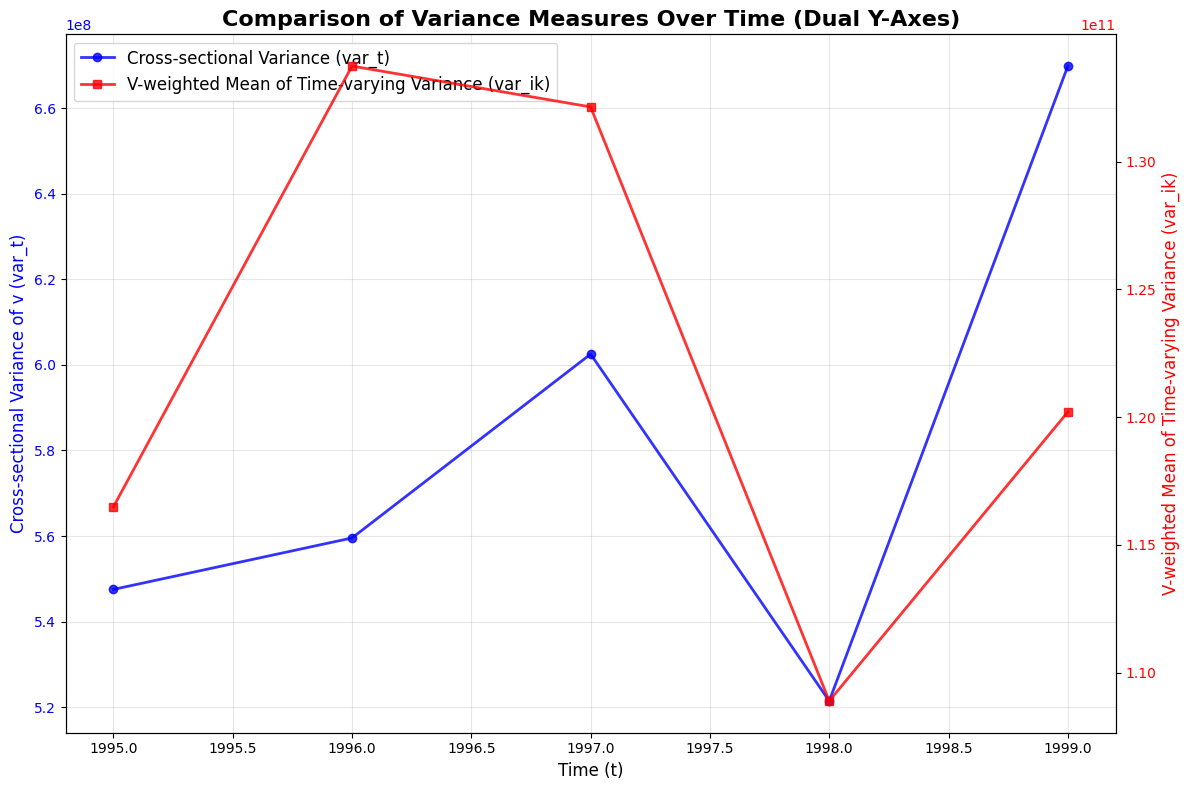

Plot saved to ../figures/variance_comparison_dual_axes.png and .pdf
Summary Statistics:
var_t - Mean: 5.80e+08, Std: 5.81e+07
Weighted var_ik - Mean: 1.22e+11, Std: 1.06e+10
Correlation between var_t and weighted var_ik: 0.315

Weighted var_ik data shape: (5, 2)


,t,weighted_var_ik
0,1995,1.164885e+11
1,1996,1.337430e+11
2,1997,1.321444e+11
3,1998,1.088911e+11
4,1999,1.202055e+11


In [ ]:
# Calculate weighted mean of var_ik by time t, using v as weights
def calculate_weighted_var_ik():
    # Remove rows with missing var_ik
    valid_data = baci_with_variance.dropna(subset=['var_ik'])
    
    weighted_var_ik_by_time = []
    for t_val in sorted(valid_data['t'].unique()):
        t_data = valid_data[valid_data['t'] == t_val]
        
        # Calculate weighted mean using v values as weights
        weights = t_data['v']
        weighted_mean = np.average(t_data['var_ik'], weights=weights)
        
        weighted_var_ik_by_time.append({'t': t_val, 'weighted_var_ik': weighted_mean})
    
    return pd.DataFrame(weighted_var_ik_by_time)

weighted_var_ik = calculate_weighted_var_ik()

# Create plot with dual y-axes
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

# Plot var_t on left y-axis
color1 = 'blue'
ax1.set_xlabel('Time (t)', fontsize=12)
ax1.set_ylabel('Cross-sectional Variance of v (var_t)', color=color1, fontsize=12)
line1 = ax1.plot(dispersion['t'], dispersion['var_t'], 
                 linewidth=2, color=color1, marker='o', markersize=6, 
                 label='Cross-sectional Variance (var_t)', alpha=0.8)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3)

# Create second y-axis for weighted var_ik
ax2 = ax1.twinx()
color2 = 'red'
ax2.set_ylabel('V-weighted Mean of Time-varying Variance (var_ik)', color=color2, fontsize=12)
line2 = ax2.plot(weighted_var_ik['t'], weighted_var_ik['weighted_var_ik'], 
                 linewidth=2, color=color2, marker='s', markersize=6, 
                 label='V-weighted Mean of Time-varying Variance (var_ik)', alpha=0.8)
ax2.tick_params(axis='y', labelcolor=color2)

# Add title and legend
ax1.set_title('Comparison of Variance Measures Over Time', fontsize=16, fontweight='bold')

# Combine legends from both axes
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=12)

# Save the plot
from pathlib import Path
figures_dir = Path("../figures")
figures_dir.mkdir(exist_ok=True)

plt.tight_layout()
plt.savefig(figures_dir / "variance_comparison_dual_axes.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Plot saved to {figures_dir}/variance_comparison_dual_axes.png and .pdf")

# Summary statistics
print("Summary Statistics:")
print(f"var_t - Mean: {dispersion['var_t'].mean():.2e}, Std: {dispersion['var_t'].std():.2e}")
print(f"Weighted var_ik - Mean: {weighted_var_ik['weighted_var_ik'].mean():.2e}, Std: {weighted_var_ik['weighted_var_ik'].std():.2e}")

# Calculate correlation
merged_data = dispersion.merge(weighted_var_ik, on='t')
correlation = merged_data['var_t'].corr(merged_data['weighted_var_ik'])
print(f"Correlation between var_t and weighted var_ik: {correlation:.3f}")

# Display the weighted variance data
print(f"\nWeighted var_ik data shape: {weighted_var_ik.shape}")
weighted_var_ik.head()